In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import os
from torchvision import transforms
import torchvision.models as models

# Проверка доступности CUDA
if torch.cuda.is_available():
    print("CUDA доступна")
    print("Имя устройства:", torch.cuda.get_device_name(0))
    print("Кол-во устройств:", torch.cuda.device_count())


CUDA доступна
Имя устройства: Tesla P100-PCIE-16GB
Кол-во устройств: 1


In [2]:
# Загрузка данных
project_dir = '/kaggle/input/mephi-ct-trainpack/'

videos_mult_mask_file = os.path.join(project_dir, 'videos_mult_mask_14082025.npy')
labels_file = os.path.join(project_dir, 'labels_220425 (1).npy')

try:
    videos_mult_mask = np.load(videos_mult_mask_file)
    labels = np.load(labels_file)
    print("Файлы загружены успешно.")
except FileNotFoundError:
    print("Файлы не найдены. Проверьте правильность пути.")

print("Размерности датасета")
print("videos_mult_mask", videos_mult_mask.shape)
print("labels", labels.shape)

Файлы загружены успешно.
Размерности датасета
videos_mult_mask (122, 54, 224, 224, 1)
labels (206, 3)


In [ ]:
# Фильтр по меткам
valid_index = np.sum(labels, axis=1) == 1
labels = labels[valid_index]


# Сначала разделим на train+val и test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    videos_mult_mask, labels, test_size=0.2, random_state=42, stratify=labels
)

# Затем разделим train+val на train и val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (77, 54, 224, 224, 1), (77, 3)
Val: (20, 54, 224, 224, 1), (20, 3)
Test: (25, 54, 224, 224, 1), (25, 3)


In [4]:
# Преобразование данных для 3D CNN
X_train = X_train[..., 0]
X_val = X_val[..., 0]
X_test = X_test[..., 0]

X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [ ]:
# Аугментации для 3D данных
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Lambda(lambda x: x / 255.0),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32) / 255.0),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [ ]:
# Создание Dataset для 3D данных
class CT3DDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        volume = self.X[idx]  
        label = self.y[idx]
        
        if self.transform:
            volume = self.transform(volume)
        else:
            volume = torch.tensor(volume, dtype=torch.float32)
            
        return volume, torch.tensor(label, dtype=torch.float32)

In [7]:
class_counts = np.sum(y_train, axis=0)
class_weights = 1. / class_counts
sample_weights = class_weights[np.argmax(y_train, axis=1)]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dataset = CT3DDataset(X_train, y_train, transform=train_transform)
val_dataset = CT3DDataset(X_val, y_val, transform=test_transform)
test_dataset = CT3DDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(Simple3DCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
        )
        
        
        with torch.no_grad():
            sample = torch.randn(1, 1, 54, 224, 224)
            features = self.features(sample)
            linear_input_size = features.view(features.size(0), -1).size(1)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(linear_input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple3DCNN(num_classes=3).to(device)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []
    best_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device).argmax(dim=1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()

        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).argmax(dim=1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                val_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc = (torch.tensor(val_preds) == torch.tensor(val_labels)).float().mean().item()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

In [ ]:
# Обучение модели с L2-регуляризацией (weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  

model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50  
)



100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Epoch 1/50
Train Loss: 1.3302 Acc: 0.2987
Val Loss: 1.1013 Acc: 0.3500


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 2/50
Train Loss: 1.1036 Acc: 0.2987
Val Loss: 1.0929 Acc: 0.3500


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Epoch 3/50
Train Loss: 1.0984 Acc: 0.3506
Val Loss: 1.0948 Acc: 0.3500


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 4/50
Train Loss: 1.0974 Acc: 0.3506
Val Loss: 1.0389 Acc: 0.5000


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 5/50
Train Loss: 1.1149 Acc: 0.2987
Val Loss: 1.0384 Acc: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Epoch 6/50
Train Loss: 1.0739 Acc: 0.3896
Val Loss: 1.0891 Acc: 0.4500


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 7/50
Train Loss: 1.1287 Acc: 0.3896
Val Loss: 0.8776 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 8/50
Train Loss: 1.1166 Acc: 0.4026
Val Loss: 1.0094 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 9/50
Train Loss: 1.0874 Acc: 0.4286
Val Loss: 0.9473 Acc: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 10/50
Train Loss: 1.0667 Acc: 0.5844
Val Loss: 0.9070 Acc: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 11/50
Train Loss: 1.0515 Acc: 0.4805
Val Loss: 1.2772 Acc: 0.2500


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 12/50
Train Loss: 1.0303 Acc: 0.4935
Val Loss: 0.9566 Acc: 0.5500


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 13/50
Train Loss: 1.0924 Acc: 0.4286
Val Loss: 0.9653 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 14/50
Train Loss: 1.0379 Acc: 0.4416
Val Loss: 1.0264 Acc: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch 15/50
Train Loss: 0.9996 Acc: 0.5844
Val Loss: 1.0235 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 16/50
Train Loss: 1.0772 Acc: 0.4935
Val Loss: 1.0422 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 17/50
Train Loss: 1.0622 Acc: 0.4286
Val Loss: 1.0480 Acc: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 18/50
Train Loss: 0.9570 Acc: 0.5455
Val Loss: 0.9942 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 19/50
Train Loss: 0.9098 Acc: 0.5714
Val Loss: 1.0309 Acc: 0.4000


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 20/50
Train Loss: 1.1297 Acc: 0.4286
Val Loss: 1.0321 Acc: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


Epoch 21/50
Train Loss: 0.9445 Acc: 0.5974
Val Loss: 1.0303 Acc: 0.5000


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 22/50
Train Loss: 0.9005 Acc: 0.5584
Val Loss: 1.0361 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch 23/50
Train Loss: 1.0010 Acc: 0.5325
Val Loss: 1.0642 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


Epoch 24/50
Train Loss: 0.8612 Acc: 0.6753
Val Loss: 1.2017 Acc: 0.4500


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


Epoch 25/50
Train Loss: 0.9418 Acc: 0.5065
Val Loss: 1.1168 Acc: 0.5000


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 26/50
Train Loss: 0.9968 Acc: 0.5065
Val Loss: 1.0628 Acc: 0.5500


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


Epoch 27/50
Train Loss: 0.9537 Acc: 0.5714
Val Loss: 1.0724 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 28/50
Train Loss: 0.9520 Acc: 0.5195
Val Loss: 1.0873 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


Epoch 29/50
Train Loss: 0.9735 Acc: 0.5195
Val Loss: 1.0297 Acc: 0.5000


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


Epoch 30/50
Train Loss: 0.9196 Acc: 0.5584
Val Loss: 1.0589 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


Epoch 31/50
Train Loss: 0.9427 Acc: 0.5584
Val Loss: 1.1108 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 32/50
Train Loss: 0.9340 Acc: 0.5325
Val Loss: 1.1056 Acc: 0.5500


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


Epoch 33/50
Train Loss: 0.8623 Acc: 0.6364
Val Loss: 1.1152 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 34/50
Train Loss: 0.9345 Acc: 0.5584
Val Loss: 1.0422 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 35/50
Train Loss: 0.8870 Acc: 0.6234
Val Loss: 1.0173 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


Epoch 36/50
Train Loss: 0.8544 Acc: 0.6883
Val Loss: 1.1152 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 37/50
Train Loss: 1.0194 Acc: 0.5065
Val Loss: 1.0128 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 38/50
Train Loss: 0.7911 Acc: 0.7013
Val Loss: 1.0482 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 39/50
Train Loss: 0.9135 Acc: 0.5325
Val Loss: 1.0832 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 40/50
Train Loss: 0.9069 Acc: 0.6234
Val Loss: 1.0440 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


Epoch 41/50
Train Loss: 0.7858 Acc: 0.6753
Val Loss: 1.1093 Acc: 0.5500


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 42/50
Train Loss: 0.7699 Acc: 0.7273
Val Loss: 1.0324 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 43/50
Train Loss: 0.8925 Acc: 0.5974
Val Loss: 1.1236 Acc: 0.5500


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 44/50
Train Loss: 0.8822 Acc: 0.5065
Val Loss: 1.1722 Acc: 0.5500


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch 45/50
Train Loss: 0.7253 Acc: 0.6753
Val Loss: 1.0830 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 46/50
Train Loss: 0.7625 Acc: 0.7273
Val Loss: 1.0417 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 47/50
Train Loss: 0.7249 Acc: 0.6883
Val Loss: 1.0979 Acc: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch 48/50
Train Loss: 1.1316 Acc: 0.5325
Val Loss: 0.9443 Acc: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 49/50
Train Loss: 0.8617 Acc: 0.6753
Val Loss: 1.0710 Acc: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 50/50
Train Loss: 0.7903 Acc: 0.7013
Val Loss: 1.0416 Acc: 0.6000


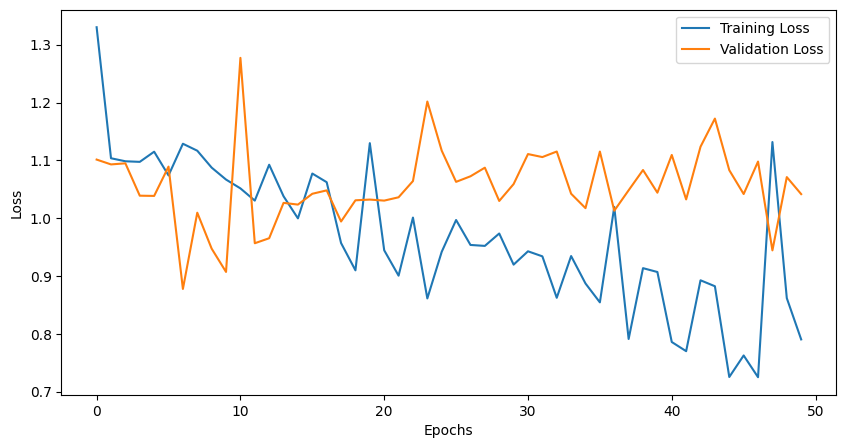

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.67      0.71         9
     Class 1       0.38      0.75      0.50         4
     Class 2       1.00      0.75      0.86        12

    accuracy                           0.72        25
   macro avg       0.71      0.72      0.69        25
weighted avg       0.81      0.72      0.75        25



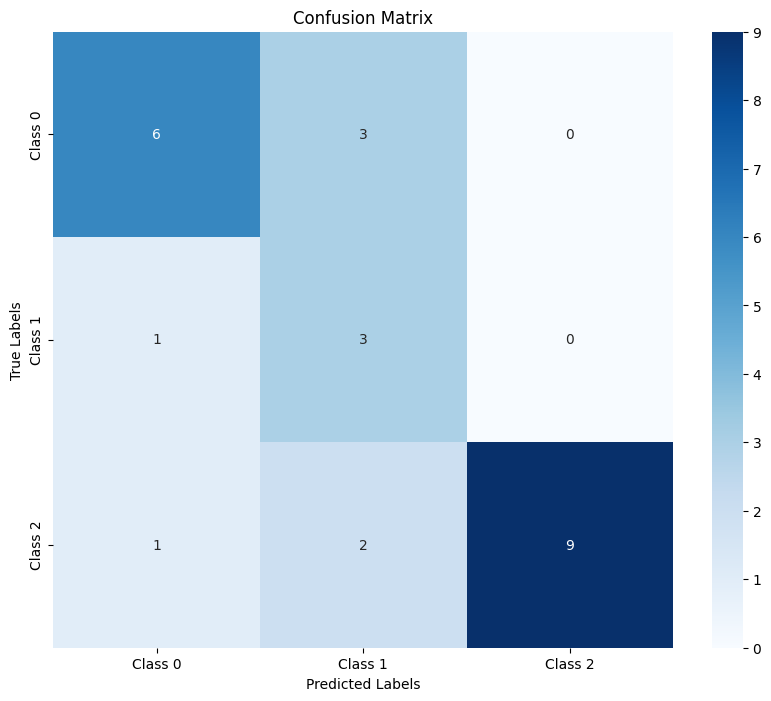

In [14]:
# Финальная оценка на тестовом наборе
def evaluate_model(model, data_loader, criterion):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    all_labels_classes = np.argmax(all_labels, axis=1)

    print("Classification Report:")
    print(classification_report(all_labels_classes, all_preds, 
                                target_names=[f"Class {i}" for i in range(all_labels.shape[1])]))
    
    cm = confusion_matrix(all_labels_classes, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"Class {i}" for i in range(all_labels.shape[1])],
                yticklabels=[f"Class {i}" for i in range(all_labels.shape[1])])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    return all_labels, all_preds, all_probs

# Оценка на тестовом наборе
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, criterion)